In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

### Loading Datasets

In [2]:
india_map= gpd.read_file("India Map\India Map 2020\india_administrative_state_boundary.shp")
master_data=pd.read_csv("Datasets\master data\master_data.csv")
gdp_current=pd.read_csv("Datasets\GSDP current.csv").dropna(how="all")
gdp_constant=pd.read_csv("Datasets\GSDP constant.csv")
population=pd.read_csv("Datasets\population.csv")
state_abb=pd.read_csv("Datasets\state_abb.csv")

state_abb.State=state_abb.State.str.upper()
state_abb.State=state_abb.State.str.replace(" AND ", " & ")

population["State"]=population.State.str.upper()
gdp_current["State\\UT"]=gdp_current["State\\UT"].str.upper()
gdp_constant["State\\UT"]=gdp_constant["State\\UT"].str.upper()

In [3]:
master_data["State_project"]=master_data.State_project.str.upper()
master_data.State_project= master_data.State_project.str.replace(" AND ", " & ")
master_data["State_company"]=master_data.State_company.str.upper()
master_data["State_company"]=master_data.State_company.str.replace(" AND ", " & ")
master_data["State_company"]=master_data["State_company"].str.replace( 'ORISSA', 'ODISHA')

data = master_data.loc[:, ["Project Amount Outlay", "Amount Spent", "State_project"]].groupby("State_project").agg("sum").drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])


data=data.merge(population, left_on="State_project", right_on="State")
data["Project Amount Outlay per capita"] =data["Project Amount Outlay"]/data["population"]
data["Amount Spent per capita"]=data["Amount Spent"]/ data["population"]

In [158]:
india_map.st_nm=india_map.st_nm.str.upper()
india_map=india_map.merge(data, left_on="st_nm", right_on="State")

gdp_current = gdp_current.iloc[:,:-2].melt(id_vars="State\\UT", var_name="year", value_name="gdp")
gdp_constant = gdp_constant.iloc[:,:-2].melt(id_vars="State\\UT", var_name="year", value_name="gdp")

gdp_current["State\\UT"] = gdp_current["State\\UT"].replace("ANDHRA PRADESH ",'ANDHRA PRADESH')
gdp_constant["State\\UT"] = gdp_constant["State\\UT"].replace("ANDHRA PRADESH ",'ANDHRA PRADESH')

In [151]:
gdp_constant[gdp_constant.year=='2018-19']

,State\UT,year,gdp
231,ANDHRA PRADESH,2018-19,623732
232,ARUNACHAL PRADESH,2018-19,16620
233,ASSAM,2018-19,231040
234,BIHAR,2018-19,381383
235,CHHATTISGARH,2018-19,237695
236,GOA,2018-19,57406
237,GUJARAT,2018-19,1183020
238,HARYANA,2018-19,517080
239,HIMACHAL PRADESH,2018-19,116570
240,JAMMU & KASHMIR,2018-19,116352


### Analyzing CSR Spending

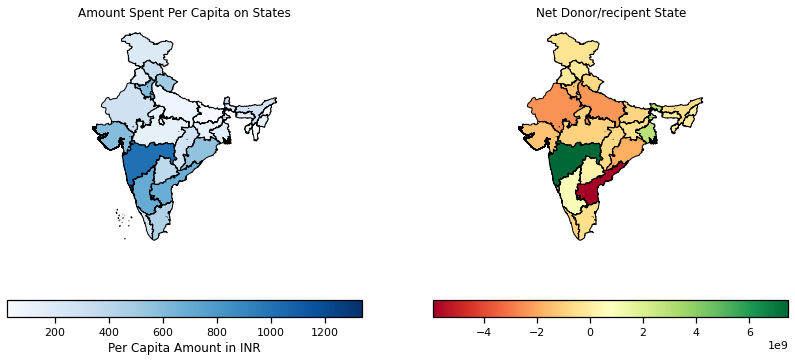

In [12]:

fig, (ax, ax2)= plt.subplots(ncols=2, figsize=(14,6))


india_map.plot(column="Amount Spent per capita", ax=ax, legend=True, edgecolor="black", cmap='Blues', 
               legend_kwds={'orientation': "horizontal", "label":"Per Capita Amount in INR"})
ax.set_title("Amount Spent Per Capita on States" )
ax.set_axis_off()

#net amount
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_project"]!="PAN INDIA"]
data=data[data["State_company"] !=np.nan]

data=data[data["State_project"]!=data["State_company"]]

recived=data.groupby(["State_project", "year"])["Amount Spent"].agg('sum').sort_values(ascending=False)
recived=recived.groupby("State_project").agg("mean")

given=data.groupby(["State_company", "year"])["Amount Spent"].agg("sum").sort_values(ascending=False)
given=given.groupby("State_company").agg("mean")

net=(given - recived).sort_values(ascending=False)

india_map=india_map.merge(pd.DataFrame(net).reset_index().rename(columns={"Amount Spent":"net"}), left_on="st_nm", right_on="index")



ax2=india_map.plot("net", ax=ax2, legend=True, edgecolor="black", cmap='RdYlGn',
                   legend_kwds={'orientation': "horizontal", "label":""})

ax2.set_title("Net Donor/recipent State" )
ax2.set_axis_off()


### Gini Coefficient for GSDP and CSR

In [13]:
def gini(array):
    #credit: 
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))    
    
for year in master_data["year"].unique():
    
    gdp=gdp_current[gdp_current["year"]==year]

    csr_spent=master_data[master_data["year"]==year].groupby("State_project")["Amount Spent"].agg("sum")

    gdp=gdp.merge(csr_spent, left_on="State\\UT", right_on="State_project")

    gdp=gdp.merge(population, left_on="State\\UT", right_on="State")

    gdp=gdp.merge(state_abb, left_on="State\\UT", right_on="State")

    gdp["gdp_pc"]=gdp["gdp"]/gdp["population"]
    gdp["csr_pc"]=gdp["Amount Spent"]/gdp["population"]


    print(year,":",gini(gdp["gdp_pc"].values), "\t",  gini(gdp["csr_pc"].values), end="\n\n")





2014-15 : 0.28216605837827763 	 0.4805642203609851

2015-16 : 0.2903071554648819 	 0.4794028646251985

2016-17 : 0.2914435137809126 	 0.47844807107607285

2017-18 : 0.2942536552305964 	 0.541729167562968

2018-19 : 0.2890889327342525 	 0.4387422076947665



### Relationship between CSR and GDP

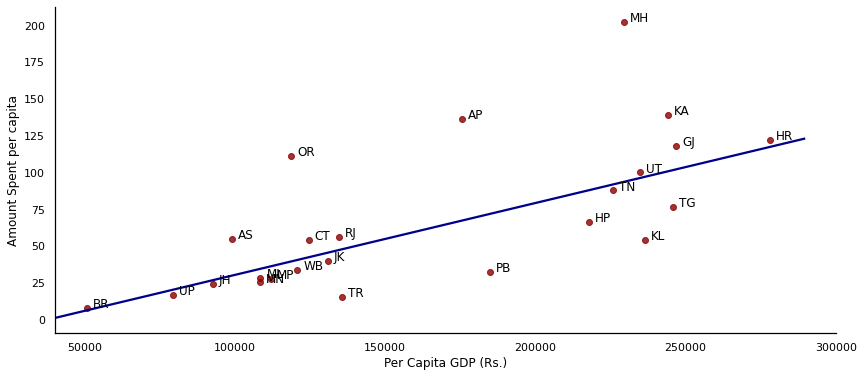

In [14]:

#{paper, notebook, talk, poster}
sns.set_context("notebook")
data = master_data.loc[:, ["Project Amount Outlay", "Amount Spent", "State_project", "year"]].groupby(["State_project", "year"]).agg("sum").drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])

data =data.reset_index()


data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent per capita"]= data["Amount Spent"]/data["population"]
data["Project Amount Outlay per capita"]= data["Project Amount Outlay"]/data["population"]

data=data[data["population"]>2500000]


data=data.groupby("State_project").agg({"Project Amount Outlay":"mean", "Amount Spent per capita":"mean", "gdp per capita":"max"})

fig,ax=plt.subplots(figsize=(14,6))

d=data.drop(["DELHI"])
d=d.merge(state_abb, left_on="State_project", right_on="State")

ax=sns.regplot(data=d, y="Amount Spent per capita", x="gdp per capita", order=1, ci=0, ax=ax, truncate=False, robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})
ax.set_xlim((40000,300000))

sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(d.abb):
    ax.annotate(txt, (d["gdp per capita"][i]+2000, d["Amount Spent per capita"][i]))

### CSR Received from Corporates within the state and outside the state

Text(0.5, 1.0, 'Per capita Amount spent by Corporates outside the State')

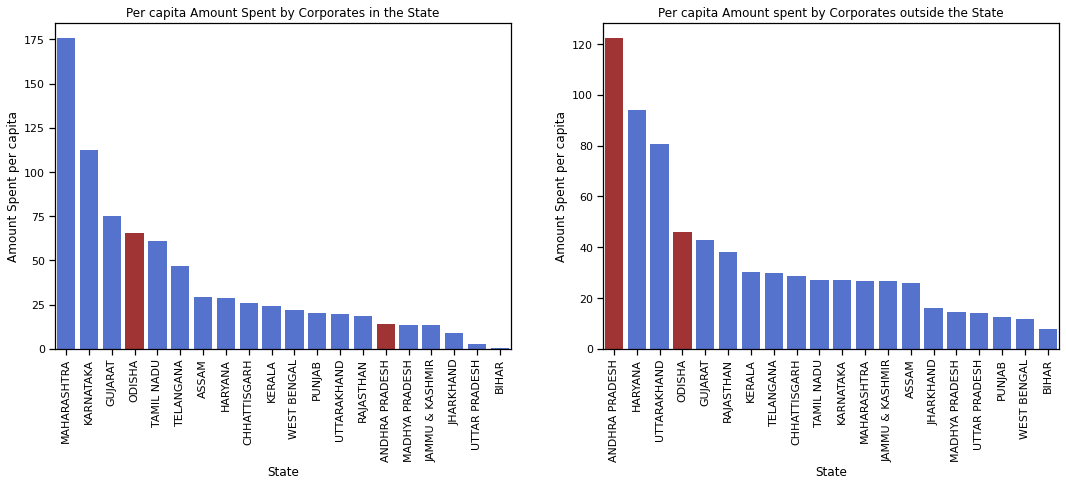

In [9]:
fig, (ax1,ax2) =plt.subplots(ncols=2, figsize=(18, 6))

st=["ANDHRA PRADESH", "ODISHA"]
#Calculating amount recived from companies within the state
data = master_data[master_data["State_project"]==master_data["State_company"]]

data=data.groupby(["State_project", "year"])["Amount Spent"].agg("sum")
data=data.groupby("State_project").agg("mean").sort_values(ascending=False)
data

data=population.merge(data, left_on="State", right_on="State_project")
data=data[data["population"]>10000000]

data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]

local_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=local_spent[~ local_spent["State"].isin(["DELHI","GOA","LAKSHADWEEP", "ARUNACHAL PRADESH","SIKKIM","CHANDIGARH", "PUDUCHERRY",])]

palette=["royalblue" if x not in st else 'firebrick' for x in data.State]

ax1 = sns.barplot(data=data, y="Amount Spent per capita", x="State", ax=ax1, palette=palette)
ax1.set_xticklabels(data.State,rotation=90)
ax1.set_title("Per capita Amount Spent by Corporates in the State")
#ax1.yaxis.grid()

#calculating amount recived from outside the state
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.groupby(["State_project", "year"])["Amount Spent"].agg("sum")
data=data.groupby("State_project").agg("mean").sort_values(ascending=False)

data=population.merge(data, left_on="State", right_on="State_project")
data=data[data["population"]>10000000]

data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]
nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=nonlocal_spent[~ nonlocal_spent["State"].isin(["DELHI","GOA", "LAKSHADWEEP"])]

nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=nonlocal_spent[~ nonlocal_spent["State"].isin(["DELHI","GOA", "LAKSHADWEEP", "SIKKIM","CHANDIGARH", "PUDUCHERRY", "ARUNACHAL PRADESH"])]

palette=["royalblue" if x not in st else 'firebrick' for x in data.State]

ax2 = sns.barplot(data=data, y="Amount Spent per capita", x="State", ax=ax2, palette=palette)
#ax2.yaxis.grid()
plt.xticks(rotation=90)
plt.title("Per capita Amount spent by Corporates outside the State")

### Trend of funds received from corporates within state and corporates outside the States:

Text(0, 0.5, 'Per Capita Amount Spent')

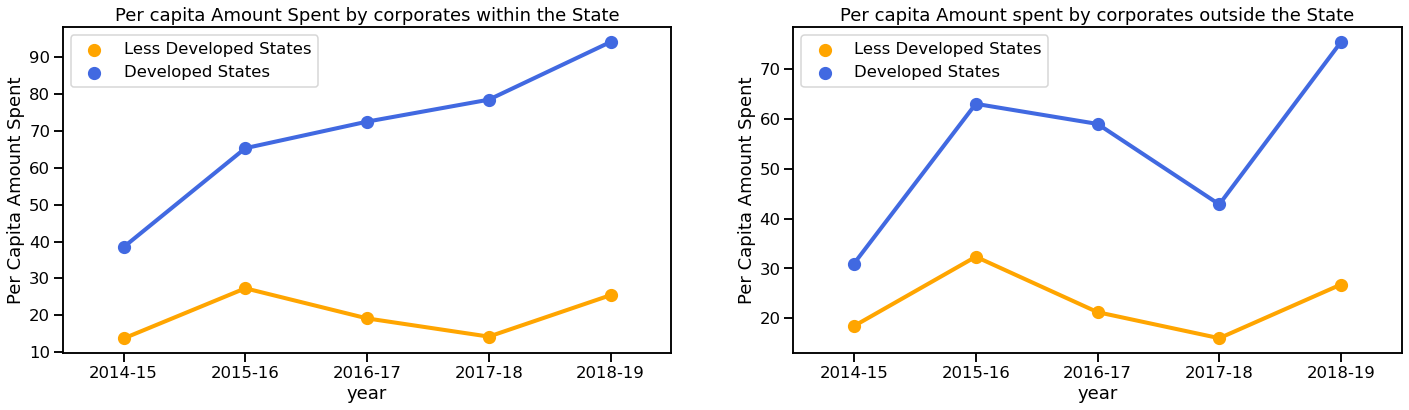

In [10]:
#{paper, notebook, talk, poster}
sns.set_context("talk")

fig,(ax, ax2)=plt.subplots(ncols=2, figsize=(24, 6))

#Trend of Per capita Amount from companies with the States
data = master_data[master_data["State_project"]==master_data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]

data['status'] = np.where((data['gdp per capita']>150000) , 1, 0)


data=data.groupby([ "State_project","year"])[["Amount Spent", "status"]].agg({"Amount Spent":"sum", "status":"mean"})

x=data.reset_index().groupby("State_project")["status"].agg("max")
data=data.reset_index().drop("status", axis=1).merge(x, on="State_project").set_index(["State_project", "year"])

ax = sns.pointplot(data=data.reset_index(),x="year", y="Amount Spent",hue="status",palette=[ "orange","royalblue"], ci=0, ax=ax, legend=True, )
leg_handles = ax.get_legend_handles_labels()[0]

ax.legend(leg_handles, ['Less Developed States', 'Developed States'])

ax.set_title("Per capita Amount Spent by corporates within the State")
ax.set_ylabel("Per Capita Amount Spent")

#Trend of States recived from companies outside the States

data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]


data['status'] = np.where((data['gdp per capita']>150000) , 1, 0)


data=data.groupby([ "State_project","year"])[["Amount Spent", "status"]].agg({"Amount Spent":"sum", "status":"max"})
x=data.reset_index().groupby("State_project")["status"].agg("max")
data=data.reset_index().drop("status", axis=1).merge(x, on="State_project").set_index(["State_project", "year"])

ax2 = sns.pointplot(data=data.reset_index(),x="year", y="Amount Spent",hue="status",palette=[ "orange","royalblue"], ci=0, ax=ax2, legend=True, )
leg_handles = ax2.get_legend_handles_labels()[0]

ax2.legend(leg_handles, ['Less Developed States', 'Developed States'])
ax2.set_title("Per capita Amount spent by corporates outside the State")
ax2.set_ylabel("Per Capita Amount Spent")

### Proportion of Amount Spent by corporates within their states:
    - If the proportion is 1 (see chart below), then the corporates within the states are spending all of their money within the state
    - If the proportion is 0, then the corporates within the states are spending all of their money on other states

In [ ]:
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_project"]!="PAN INDIA"]
data=data[~ data["State_company"].isna()]

data=data[data["State_project"]!=data["State_company"]]

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]


given=data.groupby(["State_company", "year"])["Amount Spent"].agg("sum")#.sort_values(ascending=False)
#given=given.groupby("State_company").agg("mean")


#Trend of Per capita Amount from companies with the States
data = master_data[master_data["State_project"]==master_data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]

within=data.groupby([ "State_project","year"])["Amount Spent"].agg("sum")



In [ ]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

within.index=within.index.rename(("State_company","year"))

p=within/(given+within)

p=pd.DataFrame(p)
p=p.merge(gdp_current, left_on=["State_company", "year"], right_on=['State\\UT', "year"])

p= p.merge(population, left_on="State\\UT", right_on="State")
l=p
p=p.groupby("State\\UT").agg({"Amount Spent":"mean", "population":"mean", "gdp":"max"})

p["gdp"]=(p["gdp"]/p["population"])*10000000

fig,ax=plt.subplots(figsize=(14,5))


p=p.merge(state_abb, left_on="State\\UT", right_on="State")
p=p[~ p["Amount Spent"].isna()]
p=p[p["State"]!="DELHI"]

k=p[p["Amount Spent"]<0.4]
k=k.reset_index()
p=p[p["Amount Spent"]>0.35]
p=p.reset_index()


ax.plot(k["gdp"], k["Amount Spent"], "o", color="darkred")
ax=sns.regplot(data=p, y="Amount Spent", x="gdp", order=1, ci=0, ax=ax, truncate=False, #robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})


sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(p.abb):
    ax.annotate(txt, (p["gdp"][i]+1500, p["Amount Spent"][i]+0.005))
 
for i, txt in enumerate(k.abb):
    ax.annotate(txt, (k["gdp"][i]+1500, k["Amount Spent"][i]+0.005))

plt.ylabel("Proportion of Amount Spent within the State")



$$p =\frac{\text{Money Spent on the State by the companies in the state}}{\text{Total Amount Spent by the Companies in the State}}$$



Text(0, 0.5, 'Per Capita Amount (Rs.)')

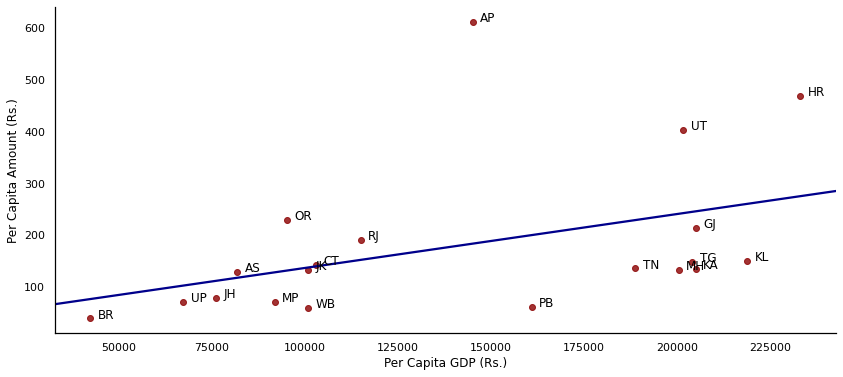

In [13]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

fig,ax=plt.subplots(figsize=(14,6))

data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.reset_index()

data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]
data=data[data["population"]>10000000]

data=data.groupby([ "State_project"])[["Amount Spent per capita", "gdp per capita"]].agg({"Amount Spent per capita":"sum", "gdp per capita":"mean"})


d=data.drop(["DELHI"])
d=d.merge(state_abb, left_on="State_project", right_on="State")

ax=sns.regplot(data=d, y="Amount Spent per capita", x="gdp per capita", order=1, ci=0, ax=ax, truncate=False, #robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})


sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(d.abb):
    ax.annotate(txt, (d["gdp per capita"][i]+2000, d["Amount Spent per capita"][i]))

ax.set_ylabel("Per Capita Amount (Rs.)")

### 

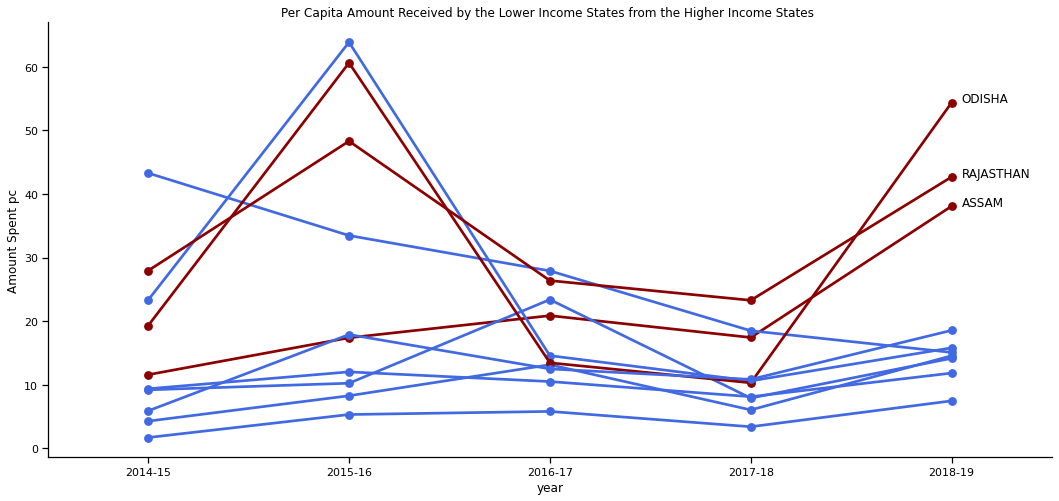

In [14]:
x=gdp_current[(gdp_current.year=="2018-19")]
x=x.merge(population, left_on="State\\UT", right_on="State")
x["gdp per capita"]=(x["gdp"]/x["population"])*10000000

rich_states = list(x[(x["gdp per capita"]>150000) & (x["population"]>10000000)]["State\\UT"])

poor_states= list(x[(x["gdp per capita"]<150000) & (x["population"]>10000000)]["State\\UT"])


flow=master_data[(master_data.State_project.isin(poor_states)) & (master_data.State_company.isin(rich_states))]


flow=flow.groupby(["year", "State_project"])["Amount Spent"].agg("sum")
flow=flow.reset_index()

flow=flow.merge(population, left_on="State_project", right_on="State")
flow["Amount Spent pc"]=flow["Amount Spent"]/flow["population"]

fig, ax=plt.subplots(figsize=(18,8))
palette=["darkred","royalblue","royalblue","royalblue","royalblue","royalblue","darkred", "darkred","royalblue", "royalblue"]
sns.pointplot(y=flow["Amount Spent pc"], x=flow.year, hue=flow.State_project, palette=palette)#

flow_19=flow[flow["year"]=="2018-19"]

flow=flow[flow.State_project.isin(["ODISHA", "RAJASTHAN","ASSAM"])]
flow['year'] = pd.Categorical(flow['year'])
flow['State_project'] = pd.Categorical(flow['State_project'])

pos_after_last_x = len(flow['year'].cat.categories)- 1 + 0.05
last_x_cat = flow['year'].cat.categories[-1]
for cat in flow['State_project'].cat.categories:
    mean_score = flow[(flow['State_project'] == cat) & (flow['year'] == last_x_cat)]['Amount Spent pc'].mean()
    ax.text(pos_after_last_x, mean_score, cat)

ax.legend().remove()
plt.title("Per Capita Amount Received by the Lower Income States from the Higher Income States ")

sns.despine(left=False, bottom=False, right=True)

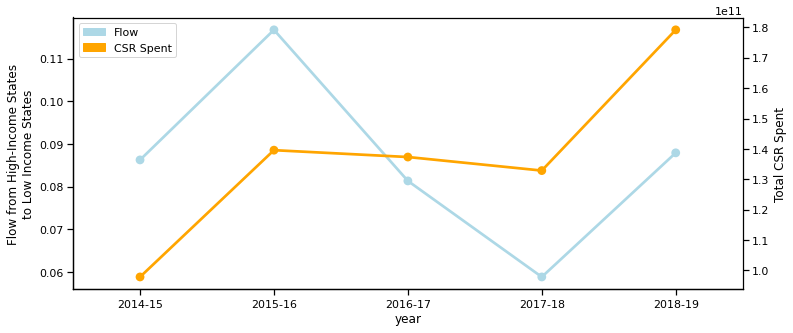

In [24]:
x=gdp_current[(gdp_current.year=="2018-19")]
x=x.merge(population, left_on="State\\UT", right_on="State")
x["gdp per capita"]=(x["gdp"]/x["population"])*10000000

rich_states = list(x[(x["gdp per capita"]>150000) & (x["population"]>10000000)]["State\\UT"])

poor_states= list(x[(x["gdp per capita"]<150000) & (x["population"]>10000000)]["State\\UT"])


flow=master_data[(master_data.State_project.isin(poor_states)) & (master_data.State_company.isin(rich_states))]
i=flow

flow=flow.groupby(["year", "State_project"])["Amount Spent"].agg("sum")
flow=flow.reset_index()

flow=flow.merge(population, left_on="State_project", right_on="State")
flow["Amount Spent pc"]=flow["Amount Spent"]/flow["population"]

flow=flow.groupby("year")["Amount Spent"].agg("sum")

#
total=master_data[master_data["State_company"].isin(rich_states)]
total=total.groupby("year")["Amount Spent"].agg("sum")

flow=flow/total


fig, ax=plt.subplots(figsize=(12,5))
ax=sns.pointplot(y=flow.values, x=flow.index, label="Flow", color="lightblue")#
sns.despine(left=False, bottom=False, right=True)

ax.set_ylabel("Flow from High-Income States\nto Low Income States")

#Total CSR Spent
data=master_data[["CIN_Number", "Amount Spent", "year" ]]
data= data.drop_duplicates()
data= data.groupby("year")["Amount Spent"].agg("sum")
data

data=master_data[["CIN_Number", "Amount Spent", "year" ]]
data= data.drop_duplicates()
data= data.groupby("year")["Amount Spent"].agg("sum")
data

ax1 = ax.twinx()
ax1.set_ylabel("Total CSR Spent")
sns.pointplot(x=data.index,y=data.values, ax=ax1, color="orange", label="CSR Spent", legend=True)


red_patch = mpatches.Patch(color='lightblue', label="Flow")
black_patch = mpatches.Patch(color='orange', label="CSR Spent")
plt.legend(handles=[red_patch, black_patch])

plt.show()

<AxesSubplot:xlabel='avg_net_profit'>

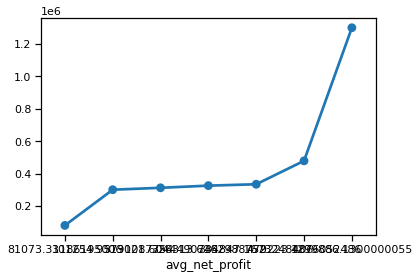

In [98]:
data=new_data[["CIN", "avg_net_profit", "year" ]]
data= data.drop_duplicates(["CIN", "year"])
data= data.groupby("year")["avg_net_profit"].agg("sum")
data

sns.pointplot(data=data, x=data.index, y=data.values)
#master_data

In [17]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0.2),  # blue  with alpha = 20%
})

### Andhra Pradesh & Odisha

<AxesSubplot:xlabel='year', ylabel='Amount Spent per capita'>

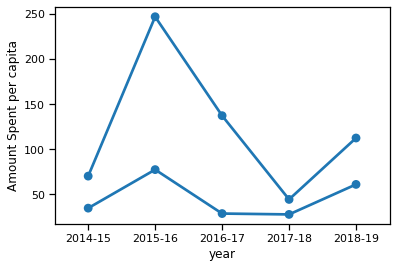

In [18]:
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]

data = data[data["State_project"] != data["State_company"]]

data=data.groupby(["State_project", "year"])[ "Amount Spent"].agg("sum")
#data=data.groupby("State_project").agg("mean").sort_values(ascending=False)

data=data.reset_index()
data=pd.DataFrame(data).merge(population, left_on="State_project", right_on="State")
data=data[data["population"]>10000000]

data["Amount Spent per capita"]=data["Amount Spent"]/data["population"]
nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

data=nonlocal_spent[~ nonlocal_spent["State"].isin(["DELHI","GOA", "LAKSHADWEEP"])]

nonlocal_spent= data.sort_values("Amount Spent per capita", ascending=False)

ap_data=nonlocal_spent[ nonlocal_spent["State"].isin(["ANDHRA PRADESH"])].sort_values("year")
odisha_data= nonlocal_spent[ nonlocal_spent["State"].isin(["ODISHA"])].sort_values("year")

sns.pointplot(data=ap_data, x="year", y="Amount Spent per capita")
sns.pointplot(data=odisha_data, x="year", y="Amount Spent per capita")


In [19]:
data=master_data[ ~ master_data["State_project"].isin(['NEC/ NOT MENTIONED',np.nan, 'SANITATION"'])]
data=data[data["State_company"] !=np.nan]
data=data[data["State_project"]=="TAMIL NADU"]

data = data[data["State_project"] != data["State_company"]]
data=data[data["Amount Spent"]!=0]
data=data.groupby("CIN_Number")["Amount Spent"].agg("sum").sort_values(ascending=False)

data[0:5].sum()/data.sum()

0.3590387001324879

In [20]:
master_data[(master_data["State_project"]=="ANDHRA PRADESH") & (master_data["year"]=="2018-19")].groupby(["year", "State_company"])["Amount Spent"].agg("sum").sort_values(ascending=False)

year     State_company     
2018-19  WEST BENGAL           2.392586e+09
         MAHARASHTRA           1.232514e+09
         TELANGANA             1.055559e+09
         ANDHRA PRADESH        8.544085e+08
         DELHI                 3.873556e+08
         TAMIL NADU            2.408251e+08
         KARNATAKA             2.024801e+08
         HARYANA               1.697600e+07
         ASSAM                 1.658200e+07
         JHARKHAND             7.744418e+06
         PUNJAB                5.249000e+06
         GUJARAT               4.005500e+06
         CHHATTISGARH          2.994000e+06
         ODISHA                2.525391e+06
         DADAR NAGAR HAVELI    2.500000e+06
         HIMACHAL PRADESH      1.756200e+06
         DAMAN & DIU           1.141001e+06
         CHANDIGARH            1.000000e+06
         KERALA                7.570200e+05
         RAJASTHAN             7.050000e+05
         MADHYA PRADESH        5.000000e+04
         UTTAR PRADESH         0.000000e+00
Name

In [21]:
master_data[(master_data["State_project"]=="UTTARAKHAND") & (master_data["year"]=="2018-19")].groupby(["year", "State_company"])["Amount Spent"].agg("sum").sort_values(ascending=False)

year     State_company   
2018-19  MAHARASHTRA         6.495602e+08
         DELHI               6.079582e+08
         UTTARAKHAND         2.064261e+08
         HIMACHAL PRADESH    5.072800e+07
         WEST BENGAL         4.339180e+07
         KARNATAKA           4.307711e+07
         PUNJAB              4.181617e+07
         TAMIL NADU          2.840300e+07
         HARYANA             2.442500e+07
         ANDHRA PRADESH      1.076400e+07
         UTTAR PRADESH       7.978172e+06
         GUJARAT             6.694493e+06
         DAMAN & DIU         4.635000e+06
         RAJASTHAN           3.123000e+06
         TELANGANA           1.445000e+06
         MADHYA PRADESH      1.000000e+06
         ASSAM               7.480000e+05
         CHHATTISGARH        5.000000e+05
         CHANDIGARH          5.000000e+05
         JHARKHAND           5.000000e+04
Name: Amount Spent, dtype: float64

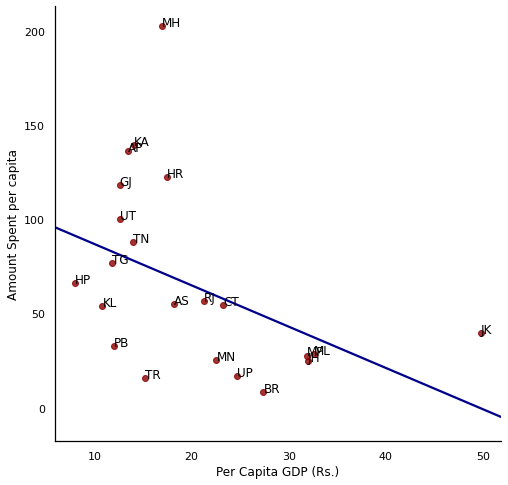

In [25]:
#{paper, notebook, talk, poster}
sns.set_context("notebook")

atc_losses=pd.read_csv("Datasets/ATC losses.csv")
atc_losses["States/UTs"]=atc_losses["States/UTs"].str.upper()


data = master_data.loc[:, ["Project Amount Outlay", "Amount Spent", "State_project", "year"]].groupby(["State_project", "year"]).agg("sum")#.drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])

data =data.reset_index()


data =data.merge(gdp_current, left_on=["State_project", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="State_project", right_on="State")

data["gdp per capita"]= (data["gdp"]/data["population"])*10000000
data["Amount Spent per capita"]= data["Amount Spent"]/data["population"]
data["Project Amount Outlay per capita"]= data["Project Amount Outlay"]/data["population"]

data=data[data["population"]>2500000]


data=data.groupby("State_project").agg({"Project Amount Outlay":"mean", "Amount Spent per capita":"mean", "gdp per capita":"max"})

fig,ax=plt.subplots(figsize=(8,8))

d=data.drop(["DELHI"])
d=d.merge(state_abb, left_on="State_project", right_on="State")
d=d.merge(atc_losses, left_on="State", right_on="States/UTs")


ax=sns.regplot(data=d, y="Amount Spent per capita", x="FY2018-19", order=1, ci=0, truncate=False, robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})
#ax.set_xlim((-50, 250))

sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Per Capita GDP (Rs.)")


for i, txt in enumerate(d.abb):
    ax.annotate(txt, (d["FY2018-19"][i], d["Amount Spent per capita"][i]))


In [44]:
import statsmodels
import statsmodels.api as sm

d= d.dropna(axis=0)
x=sm.add_constant(d["FY2018-19"])

model=statsmodels.regression.linear_model.OLS(d["csr_per_capita"],x, robust=True)

r=model.fit()

r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         csr_per_capita   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.077
Date:                Sat, 08 Jan 2022   Prob (F-statistic):              0.165
Time:                        16:47:39   Log-Likelihood:                -93.974
No. Observations:                  22   AIC:                             191.9
Df Residuals:                      20   BIC:                             194.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.8202      8.963      4.554      0.000      22.123      59.518
FY2018-19     -0.5789      0.402     -1.441      0.165      -1.417       0.259
==============================================================================
Omnibus:                        2.183   Durbin-Watson:                   2.345
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.816
Skew:                           0.661   Prob(JB):                        0.403
Kurtosis:                       2.515   Cond. No.                         51.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
d=d[['State', 'Project Amount Outlay', 'Amount Spent per capita', 'gdp per capita',
        'abb', 'FY2016-17', 'FY2017-18',
       'FY2018-19']]

d["Avg. ATC Losses"]=(d["FY2016-17"]+d["FY2017-18"]+d["FY2018-19"])/3
d

,State,Project Amount Outlay,Amount Spent per capita,gdp per capita,abb,FY2016-17,FY2017-18,FY2018-19,Avg. ATC Losses
0,ANDHRA PRADESH,1.503183e+14,136.368476,175655.483540,AP,13.77,14.26,13.41,13.813333
1,ASSAM,1.289585e+12,55.191051,99128.437815,AS,20.10,17.64,18.20,18.646667
2,BIHAR,2.410234e+13,8.466747,50718.422610,BR,41.57,33.05,27.39,34.003333
3,CHHATTISGARH,4.034922e+13,54.390924,124524.773697,CT,20.99,18.08,23.28,20.783333
4,GUJARAT,3.891017e+14,118.128198,246883.455329,GJ,14.18,12.96,12.59,13.243333
5,HARYANA,5.195857e+13,122.517258,278073.509133,HR,26.42,21.78,17.45,21.883333
6,HIMACHAL PRADESH,2.592013e+13,66.360116,217699.438365,HP,11.48,11.08,8.00,10.186667
7,JAMMU & KASHMIR,1.418846e+12,39.841068,130809.147641,JK,59.97,53.67,49.76,54.466667
8,JHARKHAND,1.561968e+13,24.764641,92668.169712,JH,35.95,32.48,31.95,33.460000
9,KARNATAKA,1.306599e+14,139.282349,243983.428053,KA,16.82,15.61,14.10,15.510000


In [60]:
new_data=pd.read_csv("scrapers/master_dataset.csv")



new_data["state"]=new_data.state.str.upper()
new_data.state= new_data.state.str.replace(" AND ", " & ")
new_data["company_hq"]=new_data.company_hq.str.upper()
new_data["company_hq"]=new_data.company_hq.str.replace(" AND ", " & ")
new_data["company_hq"]=new_data["company_hq"].str.replace( 'ORISSA', 'ODISHA')

new_data

,csr_projects,development_sector,state,district,project_amount_outlay,amount_spent,implementation_mode,year,CIN,avg_net_profit,csr_prescribed,csr_spent,local_area_spent,company_hq,RoC,class,company_type,sub_caategory,listing_status
0,NaN,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,0.00,0.0,NaN,2014-15,L00000CH1983PLC031318,0.00,0.148671,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
1,NaN,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,0.00,0.0,NaN,2015-16,L00000CH1983PLC031318,0.00,0.156473,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
2,NaN,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,0.00,0.0,NaN,2016-17,L00000CH1983PLC031318,0.00,0.060000,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
3,NaN,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,0.00,0.0,NaN,2017-18,L00000CH1983PLC031318,0.00,0.090000,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
4,NaN,NEC/ Not mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,0.00,0.0,NaN,2018-19,L00000CH1983PLC031318,0.00,0.000000,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118253,Affordable Healthcare Project,Health care,HARYANA,Ambala,23447180.42,27900000.0,Directly by company,2017-18,U74909HR1978PTC009051,117.24,2.340000,2.79,2.79,HARYANA,RoC-Delhi,Private,Other than Govt.,Company limited by shares,Unlisted
118254,Affordable Healthcare Project,Health care,HARYANA,Ambala,23447180.42,27900000.0,Directly by company,2017-18,U74909HR1978PTC009051,117.24,2.340000,2.79,2.79,HARYANA,RoC-Delhi,Private,Other than Govt.,Company limited by shares,Unlisted
118255,Rotary Ambala Cancer & General Hospital,Health care,HARYANA,Ambala,36000000.00,36000000.0,Other implementing agencies,2018-19,U74909HR1978PTC009051,153.12,3.060000,3.60,3.60,HARYANA,RoC-Delhi,Private,Other than Govt.,Company limited by shares,Unlisted
118256,NaN,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not Mentioned,0.00,0.0,NEC/ Not Mentioned,2018-19,U74909HR1978PTC009051,153.12,3.060000,3.60,3.60,HARYANA,RoC-Delhi,Private,Other than Govt.,Company limited by shares,Unlisted


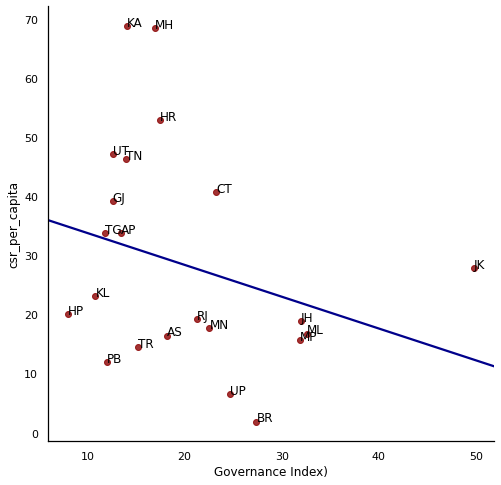

In [62]:

atc_losses=pd.read_csv("Datasets/ATC losses.csv")
atc_losses["States/UTs"]=atc_losses["States/UTs"].str.upper()


data=new_data[new_data["year"]=="2020-21"]
data = new_data.loc[:, ["project_amount_outlay", "amount_spent", "state", "year"]].groupby(["state", "year"]).agg("sum")#.drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])

data =data.reset_index()


data =data.merge(gdp_current, left_on=["state", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="state", right_on="State")

data["gdp_per_capita"]= (data["gdp"]/data["population"])*10000000
data["csr_per_capita"]= data["amount_spent"]/data["population"]
data["outlay_per_capita"]= data["project_amount_outlay"]/data["population"]

data=data[data["population"]>2500000]


data=data.groupby("state").agg({"project_amount_outlay":"mean", "csr_per_capita":"mean", "gdp_per_capita":"max"})

fig,ax=plt.subplots(figsize=(8,8))

d=data#.drop(["DELHI"])
d=d.reset_index()
d=d.merge(state_abb, left_on="state", right_on="State")
d=d.merge(atc_losses, left_on="state", right_on="States/UTs")


ax=sns.regplot(data=d, y="csr_per_capita", x="FY2018-19", order=1, ci=0, truncate=False, robust=True,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})
#ax.set_xlim((-50, 250))

sns.despine(left=False, bottom=False, right=True)

ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax.set_xlabel("Governance Index)")


for i, txt in enumerate(d.abb):
    ax.annotate(txt, (d["FY2018-19"][i], d["csr_per_capita"][i]))


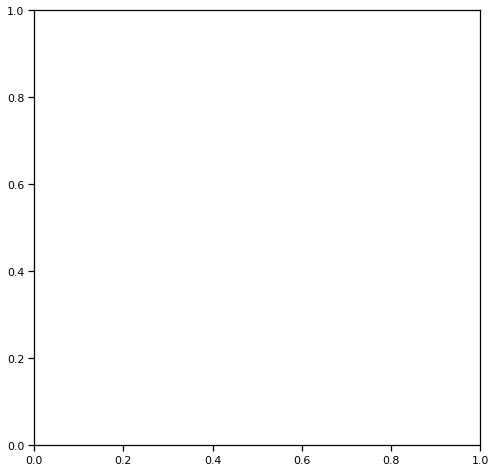

In [66]:

data=new_data[new_data["year"]=="2018-19"]
data = data.loc[:, ["project_amount_outlay", "amount_spent", "state", "year"]].groupby(["state", "year"]).agg("sum")#.drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])

data =data.reset_index()


data =data.merge(gdp_current, left_on=["state", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="state", right_on="State")

data["gdp_per_capita"]= (data["gdp"]/data["population"])*10000000
data["csr_per_capita"]= data["amount_spent"]/data["population"]
data["outlay_per_capita"]= data["project_amount_outlay"]/data["population"]

#data=data[data["population"]>2500000]


data=data.groupby("state").agg({"outlay_per_capita":"mean", "csr_per_capita":"mean", "gdp_per_capita":"max"})

fig,ax=plt.subplots(figsize=(8,8))

d=data
d=d.reset_index()
d=d.merge(state_abb, left_on="state", right_on="State")
d=d.merge(atc_losses, left_on="state", right_on="States/UTs")

d=d[['state', 'outlay_per_capita', 'csr_per_capita', 'gdp_per_capita',
     'abb', 'FY2016-17', 'FY2017-18',
       'FY2018-19']]
d["avg_ATC_losses"]=(d[ 'FY2016-17']+d[ 'FY2017-18']+d[ 'FY2018-19'])/3
d.to_csv("Datasets/aggregates/"+"2020-21"+".csv", index=False)


In [118]:

atc_losses=pd.read_csv("Datasets/ATC losses.csv")
atc_losses["States/UTs"]=atc_losses["States/UTs"].str.upper()

y= "2020-21"
data=new_data[new_data["year"]==y]
data = data.loc[:, ["project_amount_outlay", "amount_spent", "state", "year"]].groupby(["state", "year"]).agg("sum")#.drop(["PAN INDIA", 'SANITATION"','NEC/ NOT MENTIONED'])

data =data.reset_index()


data =data.merge(gdp_constant, left_on=["state", "year"], right_on=['State\\UT', "year"])

data= data.merge(population, left_on="state", right_on="State")

data["gdp_per_capita"]= (data["gdp"]/data["population"])*10000000
data["csr_per_capita"]= data["amount_spent"]/data["population"]
data["outlay_per_capita"]= data["project_amount_outlay"]/data["population"]

#data=data[data["population"]>2500000]


data=data.groupby("state").agg({"outlay_per_capita":"mean", "csr_per_capita":"mean", "population":"max","gdp_per_capita":"max"})


d=data#.drop(["DELHI"])
d=d.reset_index()
d=d.merge(state_abb, left_on="state", right_on="State")
d=d.merge(atc_losses, left_on="state", right_on="States/UTs")

d=d[['state', 'outlay_per_capita', 'csr_per_capita', 'gdp_per_capita', "population",
     'abb', 'FY2016-17', 'FY2017-18',
       'FY2018-19']]
d["avg_ATC_losses"]=(d[ 'FY2016-17']+d[ 'FY2017-18']+d[ 'FY2018-19'])/3
d.to_csv("Datasets/aggregates/"+y+".csv", index=False)
d

,state,outlay_per_capita,csr_per_capita,gdp_per_capita,population,abb,FY2016-17,FY2017-18,FY2018-19,avg_ATC_losses
0,ANDHRA PRADESH,4.997951e+04,33.744888,125810.497640,49577103,AP,13.77,14.26,13.41,13.813333
1,ARUNACHAL PRADESH,6.312907e+01,28.846152,120110.397499,1383727,AR,53.64,58.36,NaN,NaN
2,ASSAM,1.902138e+03,16.437032,74038.050123,31205576,AS,20.10,17.64,18.20,18.646667
3,BIHAR,1.078480e+04,1.894624,36636.408038,104099452,BR,41.57,33.05,27.39,34.003333
4,CHHATTISGARH,1.576067e+06,40.774822,93048.799230,25545198,CT,20.99,18.08,23.28,20.783333
5,DELHI,6.478139e+06,116.820569,341396.839553,16787941,DL,10.79,9.70,NaN,NaN
6,GOA,2.079373e+04,162.159529,393584.016948,1458545,GA,24.33,13.52,10.46,16.103333
7,GUJARAT,1.751255e+05,39.171743,195735.610301,60439692,GJ,14.18,12.96,12.59,13.243333
8,HARYANA,1.329037e+06,52.902609,203964.568197,25351462,HR,26.42,21.78,17.45,21.883333
9,HIMACHAL PRADESH,3.743302e+06,20.144328,169813.195288,6864602,HP,11.48,11.08,8.00,10.186667


In [101]:
ease_data=pd.read_html("https://www.rbi.org.in/Scripts/PublicationsView.aspx?id=20117")[1]

ease_data.columns=ease_data.iloc[0,:]+"_"+ ease_data.iloc[1,:]
ease_data=ease_data.iloc[2:-1, :]
ease_data=ease_data.rename(columns={"State/Union Territory_State/Union Territory":"state"})


In [102]:
"""
master_data["State_company"]=master_data.State_company.str.upper()
master_data["State_company"]=master_data.State_company.str.replace(" AND ", " & ")
master_data["State_company"]=master_data["State_company"].str.replace( 'ORISSA', 'ODISHA')
"""
ease_data["state"]=ease_data.state.str.replace("AND", "&")
ease_data["state"]=ease_data.state.str.upper()
ease_data["state"]=ease_data.state.str.replace( 'ORISSA', 'ODISHA')
ease_data.to_csv("Datasets/rbi_ease_of_business.csv", index=False)

In [110]:

ease_data=ease_data.replace("-", np.nan)
ease_data.to_csv("Datasets/rbi_ease_of_business.csv", index=False)

In [182]:
import json
with open('Datasets/GGI.json', 'r') as datafile:
    data = json.load(datafile)
    ggi_data = pd.DataFrame(data)

In [183]:
ggi_composite = ggi_data[ggi_data.field_category=="Composite Ranking"][["State", "States_category", "points"]]

In [184]:
ggi_composite=ggi_composite.replace({"A&N Islands":"ANDAMAN & NICOBAR ISLANDS", "D&N Haveli":"Dadra & Nagar Haveli", "J & K":"JAMMU & KASHMIR" })
ggi_composite.State=ggi_composite.State.str.upper()
ggi_composite.to_csv("Datasets/ggi_composite.csv", index=False)

In [38]:
data=pd.read_csv("scrapers/master_dataset.csv")
#data=data[data.year=="2020-21"]
data=data[data.state !="PAN India"]
data=data[(data.project_amount_outlay>0) & (data.amount_spent>0)]

data.district.value_counts()[["NEC/ Not mentioned", 'NEC/Not Mentioned', 'NEC/Not Mentioned']]/data.district.value_counts().sum()

NEC/ Not mentioned    0.554786
NEC/Not Mentioned     0.000441
NEC/Not Mentioned     0.000441
Name: district, dtype: float64

In [5]:
master_data.groupby(["year", "State_project"])["Amp"].agg("sum")

,CSR Project(s),Project Amount Outlay,Amount Spent,year,Development Sector(s),State_project,District_project,Mode of Implementation,company name,CIN_Number,Average Net Profit,CSR Prescribed Expenditure,CSR Spent,Local Area Spent,State_company,RoC,Class,Company Type,Sub Category,Listing Status
0,NaN,0.00,0.0,2014-15,NEC/ Not Mentioned,NEC/ NOT MENTIONED,NEC/ Not mentioned,NaN,SAB INDUSTRIES LIMITED,L00000CH1983PLC031318,0.00,0.148671,0.00,0.00,CHANDIGARH,RoC-Chandigarh,Public,Non-govt company,Company limited by Shares,Listed
1,roof water proofing,500000.00,0.0,2014-15,Environmental Sustainability,MADHYA PRADESH,Hoshangabad,Directly,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
2,training to the poor classes of people fro emp...,800000.00,0.0,2014-15,Special Education,MADHYA PRADESH,Hoshangabad,Directly,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
3,education society,500000.00,0.0,2014-15,Education,MADHYA PRADESH,Hoshangabad,Directly,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
4,public waiting hall,500000.00,0.0,2014-15,Rural Development Projects,MADHYA PRADESH,Hoshangabad,Other Implementing Agency,Natraj Proteins Limited,L00153MP1990PLC006090,11.38,0.210000,0.21,0.01,MADHYA PRADESH,RoC-Gwalior,Public,Other than Govt.,Company limited by shares,Listed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201044,S Cube Infra,200000.00,200000.0,2018-19,Rural development projects,TELANGANA,NEC/ Not mentioned,Directly by company,ASIAN INSTITUTE OF GASTROENTEROLOGY PRIVATE LI...,U99999TG1994PTC018352,97.23,1.940000,1.64,1.64,TELANGANA,RoC-Hyderabad,Private,Other than Govt.,Company limited by Shares,Unlisted
201045,Lake View Sports Foundation,4200000.00,4200000.0,2018-19,Rural development projects,TELANGANA,NEC/ Not mentioned,Directly by company,ASIAN INSTITUTE OF GASTROENTEROLOGY PRIVATE LI...,U99999TG1994PTC018352,97.23,1.940000,1.64,1.64,TELANGANA,RoC-Hyderabad,Private,Other than Govt.,Company limited by Shares,Unlisted
201046,Research for promoting health care including p...,12000000.00,12000000.0,2018-19,Rural development projects,TELANGANA,NEC/ Not mentioned,Other implementing agencies,ASIAN INSTITUTE OF GASTROENTEROLOGY PRIVATE LI...,U99999TG1994PTC018352,97.23,1.940000,1.64,1.64,TELANGANA,RoC-Hyderabad,Private,Other than Govt.,Company limited by Shares,Unlisted
201047,Contribution to Akshaya Patra,1207000.00,1207000.0,2018-19,"Poverty, Eradicating Hunger, Malnutrition",TELANGANA,NEC/ Not mentioned,By Trusts/Societies/Section 8 company set up b...,ECIL-RAPISCAN LIMITED,U99999TG1995PLC019129,0.00,0.120000,0.12,0.00,TELANGANA,RoC-Hyderabad,Public,Other than Govt.,Company limited by shares,Unlisted


In [220]:
data=pd.read_csv("scrapers/master_dataset.csv")

data = data.groupby(["state", "year"])[["amount_spent","project_amount_outlay"]].agg("sum").reset_index()

data.state=data.state.str.upper().str.replace(" AND ", " & ").str.replace( 'ORISSA', 'ODISHA')
data

,state,year,amount_spent,project_amount_outlay
0,ANDAMAN & NICOBAR,2016-17,6.000000e+05,6.000000e+05
1,ANDAMAN & NICOBAR,2017-18,2.000000e+06,2.000000e+06
2,ANDAMAN & NICOBAR,2018-19,4.089000e+05,4.089000e+05
3,ANDHRA PRADESH,2014-15,9.879000e+08,1.532243e+11
4,ANDHRA PRADESH,2015-16,2.954867e+09,5.353384e+09
...,...,...,...,...
268,WEST BENGAL,2018-19,1.108754e+09,5.082142e+12
269,WEST BENGAL,2019-20,1.241480e+09,1.668863e+09
270,WEST BENGAL,2020-21,2.179352e+08,2.397672e+08
271,JHARKHAND,2017-18,4.568360e+08,0.000000e+00


In [221]:
gdp=pd.read_csv("Datasets/per capita Net GSDP.csv")

gdp = gdp.melt(id_vars="year", var_name="state", value_name="gsdp_pc")
gdp.year= gdp.year.str.strip()


data = data.merge(gdp, how="left")

In [222]:
data = data.merge(population, left_on="state", right_on="State", how="left")

data=data.drop("State", axis=1)
data

,state,year,amount_spent,project_amount_outlay,gsdp_pc,population
0,ANDAMAN & NICOBAR,2016-17,6.000000e+05,6.000000e+05,NaN,NaN
1,ANDAMAN & NICOBAR,2017-18,2.000000e+06,2.000000e+06,NaN,NaN
2,ANDAMAN & NICOBAR,2018-19,4.089000e+05,4.089000e+05,NaN,NaN
3,ANDHRA PRADESH,2014-15,9.879000e+08,1.532243e+11,93903,49577103.0
4,ANDHRA PRADESH,2015-16,2.954867e+09,5.353384e+09,108002,49577103.0
...,...,...,...,...,...,...
268,WEST BENGAL,2018-19,1.108754e+09,5.082142e+12,103944,91276115.0
269,WEST BENGAL,2019-20,1.241480e+09,1.668863e+09,113163,91276115.0
270,WEST BENGAL,2020-21,2.179352e+08,2.397672e+08,121267,91276115.0
271,JHARKHAND,2017-18,4.568360e+08,0.000000e+00,67484,32988134.0


In [223]:
panel=data

In [224]:
atc_losses=pd.read_csv("Datasets/ATC losses.csv")
atc_losses["States/UTs"]=atc_losses["States/UTs"].str.upper()
atc_losses=atc_losses.drop("Sl. No", axis=1)


#.melt(id_vars="State\\UT", var_name="year", value_name="gdp")
atc_losses= atc_losses.melt(id_vars="States/UTs", var_name="year",value_name="atc_losses")

atc_losses.year= [i[2:] for i in atc_losses.year]
atc_losses

,States/UTs,year,atc_losses
0,ANDHRA PRADESH,2016-17,13.77
1,ARUNACHAL PRADESH,2016-17,53.64
2,ASSAM,2016-17,20.10
3,BIHAR,2016-17,41.57
4,CHHATTISGARH,2016-17,20.99
...,...,...,...
97,TRIPURA,2018-19,15.24
98,UTTAR PRADESH,2018-19,24.64
99,UTTARAKHAND,2018-19,12.64
100,WEST BENGAL,2018-19,NaN


In [196]:
panel= pd.read_csv("CSR Statewise aggregates.csv")
panel

,year,state,amount_spent,project_amount_outlay,gsdp_pc,population,abb
0,2014-15,ANDHRA PRADESH,9.377000e+08,3.204300e+09,93903,49577103,AP
1,2015-16,ANDHRA PRADESH,2.734867e+09,4.956384e+09,108002,49577103,AP
2,2016-17,ANDHRA PRADESH,1.589777e+09,1.462864e+10,120676,49577103,AP
3,2017-18,ANDHRA PRADESH,1.330570e+09,1.820478e+09,138299,49577103,AP
4,2018-19,ANDHRA PRADESH,1.218019e+09,1.189384e+13,152286,49577103,AP
...,...,...,...,...,...,...,...
216,2015-16,NAGALAND,2.600000e+06,2.600000e+06,82466,1978502,NL
217,2017-18,NAGALAND,1.430000e+07,1.430000e+07,102003,1978502,NL
218,2018-19,NAGALAND,1.450000e+06,1.450000e+06,109198,1978502,NL
219,2019-20,NAGALAND,2.541144e+07,2.640000e+07,120518,1978502,NL


In [225]:
panel=panel.merge(atc_losses, left_on=["state", "year"], right_on=["States/UTs", "year"], how="left")
panel=panel.drop("States/UTs", axis=1)
panel

,state,year,amount_spent,project_amount_outlay,gsdp_pc,population,atc_losses
0,ANDAMAN & NICOBAR,2016-17,6.000000e+05,6.000000e+05,NaN,NaN,NaN
1,ANDAMAN & NICOBAR,2017-18,2.000000e+06,2.000000e+06,NaN,NaN,NaN
2,ANDAMAN & NICOBAR,2018-19,4.089000e+05,4.089000e+05,NaN,NaN,NaN
3,ANDHRA PRADESH,2014-15,9.879000e+08,1.532243e+11,93903,49577103.0,NaN
4,ANDHRA PRADESH,2015-16,2.954867e+09,5.353384e+09,108002,49577103.0,NaN
...,...,...,...,...,...,...,...
268,WEST BENGAL,2018-19,1.108754e+09,5.082142e+12,103944,91276115.0,NaN
269,WEST BENGAL,2019-20,1.241480e+09,1.668863e+09,113163,91276115.0,NaN
270,WEST BENGAL,2020-21,2.179352e+08,2.397672e+08,121267,91276115.0,NaN
271,JHARKHAND,2017-18,4.568360e+08,0.000000e+00,67484,32988134.0,32.48


In [226]:
business_ease=pd.read_csv("Datasets/rbi_ease_of_business.csv")
business_ease=business_ease[['state','2015_Score','2016_Score','2017_Score']]

business_ease= business_ease.melt(id_vars="state", var_name="year", value_name="business_ease")

business_ease.year= [i[:4] for i in business_ease.year]
business_ease

,state,year,business_ease
0,ANDHRA PRADESH,2015,70.12
1,ARUNACHAL PRADESH,2015,1.23
2,ASSAM,2015,14.48
3,BIHAR,2015,16.41
4,CHHATTISGARH,2015,62.45
...,...,...,...
103,DADRA & NAGAR HAVELI,2017,21.88
104,DELHI,2017,31.69
105,DAMAN & DIU,2017,28.69
106,LAKSHADWEEP,2017,NaN


In [227]:
panel["cyear"] = [i[:2]+i[-2:] for i in panel.year]

panel=panel.merge(business_ease, left_on=["cyear", "state"], right_on=["year", "state"], suffixes=["", "x"], how="left")

panel=panel.drop("yearx", axis=1)

panel

,state,year,amount_spent,project_amount_outlay,gsdp_pc,population,atc_losses,cyear,business_ease
0,ANDAMAN & NICOBAR,2016-17,6.000000e+05,6.000000e+05,NaN,NaN,NaN,2017,NaN
1,ANDAMAN & NICOBAR,2017-18,2.000000e+06,2.000000e+06,NaN,NaN,NaN,2018,NaN
2,ANDAMAN & NICOBAR,2018-19,4.089000e+05,4.089000e+05,NaN,NaN,NaN,2019,NaN
3,ANDHRA PRADESH,2014-15,9.879000e+08,1.532243e+11,93903,49577103.0,NaN,2015,70.12
4,ANDHRA PRADESH,2015-16,2.954867e+09,5.353384e+09,108002,49577103.0,NaN,2016,98.78
...,...,...,...,...,...,...,...,...,...
268,WEST BENGAL,2018-19,1.108754e+09,5.082142e+12,103944,91276115.0,NaN,2019,NaN
269,WEST BENGAL,2019-20,1.241480e+09,1.668863e+09,113163,91276115.0,NaN,2020,NaN
270,WEST BENGAL,2020-21,2.179352e+08,2.397672e+08,121267,91276115.0,NaN,2021,NaN
271,JHARKHAND,2017-18,4.568360e+08,0.000000e+00,67484,32988134.0,32.48,2018,NaN


In [228]:
ggi = pd.read_csv("Datasets/ggi_composite.csv")

panel= panel.merge(ggi, left_on="state", right_on="State", how="left")

panel = panel.drop(["State"], axis=1)

panel=panel.rename(columns={"points":"governance_score"})
panel

,state,year,amount_spent,project_amount_outlay,gsdp_pc,population,atc_losses,cyear,business_ease,States_category,governance_score
0,ANDAMAN & NICOBAR,2016-17,6.000000e+05,6.000000e+05,NaN,NaN,NaN,2017,NaN,NaN,NaN
1,ANDAMAN & NICOBAR,2017-18,2.000000e+06,2.000000e+06,NaN,NaN,NaN,2018,NaN,NaN,NaN
2,ANDAMAN & NICOBAR,2018-19,4.089000e+05,4.089000e+05,NaN,NaN,NaN,2019,NaN,NaN,NaN
3,ANDHRA PRADESH,2014-15,9.879000e+08,1.532243e+11,93903,49577103.0,NaN,2015,70.12,Big States,5.05
4,ANDHRA PRADESH,2015-16,2.954867e+09,5.353384e+09,108002,49577103.0,NaN,2016,98.78,Big States,5.05
...,...,...,...,...,...,...,...,...,...,...,...
268,WEST BENGAL,2018-19,1.108754e+09,5.082142e+12,103944,91276115.0,NaN,2019,NaN,Big States,4.84
269,WEST BENGAL,2019-20,1.241480e+09,1.668863e+09,113163,91276115.0,NaN,2020,NaN,Big States,4.84
270,WEST BENGAL,2020-21,2.179352e+08,2.397672e+08,121267,91276115.0,NaN,2021,NaN,Big States,4.84
271,JHARKHAND,2017-18,4.568360e+08,0.000000e+00,67484,32988134.0,32.48,2018,NaN,Big States,4.23


In [229]:
hdi= pd.read_excel("Datasets/GDL-Sub-national-HDI-data.xlsx")

hdi=hdi.drop(["Country", "ISO_Code", "Level", "GDLCODE"], axis=1)

hdi = hdi.melt(id_vars="Region", var_name="year", value_name="hdi")

hdi.Region= hdi.Region.str.upper().str.replace(" AND ", " & ").str.replace( 'ORISSA', 'ODISHA')
hdi.year = [str(i) for i in hdi.year]

panel = panel.merge(hdi, left_on=["cyear", "state"], right_on=["year", "Region"], how="left",suffixes=("", "_x"))


panel = panel.drop(["Region", "year_x"], axis=1)

panel

,state,year,amount_spent,project_amount_outlay,gsdp_pc,population,atc_losses,cyear,business_ease,States_category,governance_score,hdi
0,ANDAMAN & NICOBAR,2016-17,6.000000e+05,6.000000e+05,NaN,NaN,NaN,2017,NaN,NaN,NaN,NaN
1,ANDAMAN & NICOBAR,2017-18,2.000000e+06,2.000000e+06,NaN,NaN,NaN,2018,NaN,NaN,NaN,NaN
2,ANDAMAN & NICOBAR,2018-19,4.089000e+05,4.089000e+05,NaN,NaN,NaN,2019,NaN,NaN,NaN,NaN
3,ANDHRA PRADESH,2014-15,9.879000e+08,1.532243e+11,93903,49577103.0,NaN,2015,70.12,Big States,5.05,0.627
4,ANDHRA PRADESH,2015-16,2.954867e+09,5.353384e+09,108002,49577103.0,NaN,2016,98.78,Big States,5.05,0.633
...,...,...,...,...,...,...,...,...,...,...,...,...
268,WEST BENGAL,2018-19,1.108754e+09,5.082142e+12,103944,91276115.0,NaN,2019,NaN,Big States,4.84,0.641
269,WEST BENGAL,2019-20,1.241480e+09,1.668863e+09,113163,91276115.0,NaN,2020,NaN,Big States,4.84,NaN
270,WEST BENGAL,2020-21,2.179352e+08,2.397672e+08,121267,91276115.0,NaN,2021,NaN,Big States,4.84,NaN
271,JHARKHAND,2017-18,4.568360e+08,0.000000e+00,67484,32988134.0,32.48,2018,NaN,Big States,4.23,0.595


In [232]:
gdi = pd.read_excel("Datasets/GDL-Sub-national-GDI-data.xlsx")

gdi= gdi.drop(["Country", "ISO_Code", "Level", "GDLCODE"], axis=1)

gdi = gdi.melt(id_vars="Region", var_name="year", value_name="gdi")

gdi.Region=gdi.Region.str.upper().str.replace(" AND ", " & ").str.replace( 'ORISSA', 'ODISHA')
gdi.year=[str(i) for i in gdi.year]

panel=panel.merge(gdi, left_on=["state", "cyear"], right_on=["Region", "year" ], how="left", suffixes=("", "_x"))

panel= panel.drop(["Region", "year_x"], axis=1)

In [238]:
panel=panel.rename(columns={"year":"FY", "cyear":'year'})
panel=panel[['state', 'year', 'FY', 'amount_spent', 'project_amount_outlay', 'gsdp_pc',
       'population', 'atc_losses', 'business_ease', 'States_category',
       'governance_score', 'hdi', 'gdi']]
panel

,state,year,FY,amount_spent,project_amount_outlay,gsdp_pc,population,atc_losses,business_ease,States_category,governance_score,hdi,gdi
0,ANDAMAN & NICOBAR,2017,2016-17,6.000000e+05,6.000000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANDAMAN & NICOBAR,2018,2017-18,2.000000e+06,2.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANDAMAN & NICOBAR,2019,2018-19,4.089000e+05,4.089000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANDHRA PRADESH,2015,2014-15,9.879000e+08,1.532243e+11,93903,49577103.0,NaN,70.12,Big States,5.05,0.627,0.811
4,ANDHRA PRADESH,2016,2015-16,2.954867e+09,5.353384e+09,108002,49577103.0,NaN,98.78,Big States,5.05,0.633,0.819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,WEST BENGAL,2019,2018-19,1.108754e+09,5.082142e+12,103944,91276115.0,NaN,NaN,Big States,4.84,0.641,0.846
269,WEST BENGAL,2020,2019-20,1.241480e+09,1.668863e+09,113163,91276115.0,NaN,NaN,Big States,4.84,NaN,NaN
270,WEST BENGAL,2021,2020-21,2.179352e+08,2.397672e+08,121267,91276115.0,NaN,NaN,Big States,4.84,NaN,NaN
271,JHARKHAND,2018,2017-18,4.568360e+08,0.000000e+00,67484,32988134.0,32.48,NaN,Big States,4.23,0.595,0.795


In [239]:
panel.to_csv("CSR Statewise aggregates.csv")

In [25]:
data=pd.read_csv("scrapers/master_dataset.csv")
data["industry"]= [i[1:3] for i in data.CIN]

activity_data=data.groupby("industry")["amount_spent"].agg("sum")
len(activity_data)

74

In [15]:

csr = activity_data/activity_data.sum()

In [26]:
profits= data.groupby("industry")["csr_prescribed"].agg("sum")
profits= profits/profits.sum()
profits


industry
00    0.000351
01    0.002010
02    0.022980
03    0.000029
04    0.000459
        ...   
90    0.000018
91    0.000063
92    0.003192
93    0.004706
99    0.024252
Name: csr_prescribed, Length: 74, dtype: float64

In [27]:
diff= csr - profits
diff.sort_values()

industry
10   -0.143161
85   -0.039158
74   -0.027268
02   -0.020565
23   -0.007478
        ...   
24    0.011880
64    0.014067
45    0.014273
72    0.040734
65    0.066155
Length: 74, dtype: float64

<AxesSubplot:>

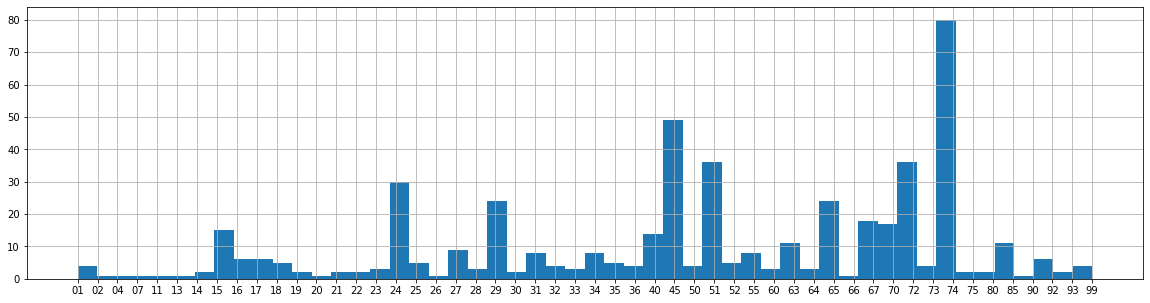

In [54]:
unit_data=data.groupby(["industry", "CIN"])[["amount_spent", "csr_prescribed"]].agg("sum")

prop = unit_data.amount_spent/unit_data.csr_prescribed
prop=prop.reset_index().sort_values(by=0)

prop=prop.dropna()
prop=prop[prop[0]!=np.inf]
prop[-500:].industry.sort_values().hist(figsize=(20,5), bins=52)

<ipython-input-73-543435c06f77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry74["sub_industry"]=[i[1:6] for i in industry74.CIN]


<AxesSubplot:>

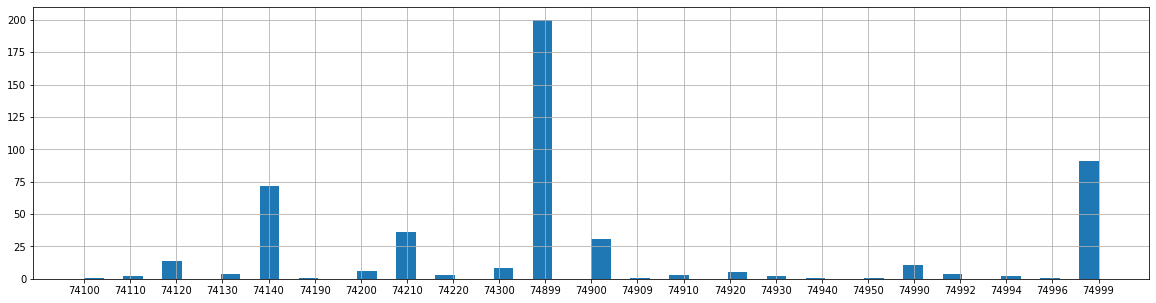

In [73]:
industry74=data[data.industry=="74"]

industry74["sub_industry"]=[i[1:6] for i in industry74.CIN]

unit_data=industry74.groupby(["sub_industry", "CIN"])[["amount_spent", "csr_prescribed"]].agg("sum")

prop = unit_data.amount_spent/unit_data.csr_prescribed
prop=prop.reset_index().sort_values(by=0)

prop=prop.dropna()
prop=prop[prop[0]!=np.inf]
prop[-500:].sub_industry.sort_values().hist(figsize=(20,5), bins=52)

In [80]:
t=industry74[industry74.sub_industry=="74899"].groupby("CIN")["amount_spent"].agg("sum").sort_values()

t[-20:]

CIN
L74899DL1956GOI002674    2.169000e+08
U74899DL1971GOI005600    2.326000e+08
U74899DL1989PTC037732    2.526250e+08
L74899DL1993GOI053677    2.527551e+08
L74899DL1992PLC050333    3.240000e+08
U74899DL1995PTC074334    3.380814e+08
L74899HR1944PLC039088    3.650000e+08
U74899DL1994PTC059865    3.671638e+08
U74899DL1995PLC067527    4.008000e+08
U74899DL1995PLC073245    4.291050e+08
L74899DL1960GOI003335    4.626590e+08
U74899DL1993PTC051764    6.314500e+08
U74899DL1970GOI005276    6.678000e+08
L74899DL1989PLC034923    7.343000e+08
U74899DL1965PLC004518    9.461590e+08
U74899DL1993PTC055062    1.051460e+09
L74899DL1998PLC093073    1.457407e+09
L74899DL1995PLC070609    1.789100e+09
L74899DL1964GOI004281    3.709455e+09
L74899DL1993GOI054155    3.060120e+10
Name: amount_spent, dtype: float64

In [4]:
data=pd.read_csv("scrapers/master_dataset.csv")
agg=pd.read_csv("CSR Statewise aggregates.csv")

data["year"]= [i[0:2]+i[-2:] for i in data["year"]]
data['year']=pd.to_numeric(data["year"])
data["company_hq"]=data.company_hq.str.upper().str.replace(" AND ", " & ").str.replace( 'ORISSA', 'ODISHA')

agg=agg.drop(["amount_spent", "project_amount_outlay"], axis=1)

final=data.merge(agg, left_on=["company_hq", "year"], right_on=["state", "year"], suffixes=("", "_x"), how="left")

final=final.drop(['Unnamed: 0', 'state_x', 'FY'], axis=1)
final.to_csv("master_data_plus.csv", index=False)

In [24]:
type(sqlalchemy.null())

sqlalchemy.sql.elements.Null